In [1]:
import os
import seaborn as sns
import pandas as pd
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
import matplotlib.pyplot as plt
plt.style.use(['science'])

--

### Collect results and process 

data collection and generating one csv

In [2]:
path = "../../data/coevolution_res/finer2"
grid_res = list()
means = list()
alls = dict()
for filename in os.listdir(path):
        if filename.endswith('report.csv'):
            df = pd.read_csv(os.path.join(path,filename), index_col = 0)
            #filename = filename.replace('comm_rate','commrate').replace('shared_discount','shareddiscount')
            for h in filename[:-4].split("-")[1:]:
                field = h.split("_")[0]
                val = h.split("_")[-1]
                try: 
                    val = float(val)
                except:
                    pass
                df[field]= val  
            df['travel_decisions'] = df.travel_decisions.apply(lambda x: x.split("\n")[1:-1])
            df['travel_decisions'] = df['travel_decisions'].apply(lambda x: dict([(_.split(" ")[0],int(_.split(" ")[-1])) for _ in x]))
            df['out'] = df.travel_decisions.apply(lambda x: x.get('out',0))
            df['rh'] = df.travel_decisions.apply(lambda x: x.get('rh',0))
            df['rp'] = df.travel_decisions.apply(lambda x: x.get('rp',0))
            df['filename'] = filename.split("/")[-1]
            df.columns = [_.replace("_"," ") for _ in df.columns]
        
            means.append(df[df.day>=(df.day.max()-5)].mean())
            grid_res.append(df)
            alls[filename] = df
            
means = pd.concat(means, axis = 1).T.reset_index()
grid_res = pd.concat(grid_res)
grid_res.nV=grid_res.nV.astype(int)
grid_res.nP=grid_res.nP.astype(int)
means.nV=means.nV.astype(int)
means.nP=means.nP.astype(int)
means['share out'] = means['out']/means.nP
means['share rh'] = means['rh']/means.nP
means['share rp'] = means['rp']/means.nP
means['share drivers'] = means['n drivers']/means.nV
grid_res['$c$'] = grid_res['comm rate']
grid_res['$p$'] = grid_res['discount']
means['$c$'] = means['comm rate'].round(2)
means['$p$'] = means['discount'].round(2)
df.head()

,day,nP,nV,comm rate,discount,travel decisions,n trav,n drivers,fare,commision,...,n actually sharing,n shared rides,unserved,comm,shared,dt,out,rh,rp,filename
0,0,1100.0,60.0,1.1,0.2,"{'out': 435, 'rh': 308, 'rp': 357}",665,60,0.0000,0.0000,...,241,120,0,1.1,0.2,report,435,308,357,BIG-nP_1100-nV_60-comm_rate_1.1-shared_discoun...
1,1,1100.0,60.0,1.1,0.2,"{'out': 453, 'rh': 323, 'rp': 324}",647,34,0.0000,0.0000,...,204,102,0,1.1,0.2,report,453,323,324,BIG-nP_1100-nV_60-comm_rate_1.1-shared_discoun...
2,2,1100.0,60.0,1.1,0.2,"{'out': 513, 'rh': 282, 'rp': 305}",587,43,3333.2628,239.1816,...,192,96,0,1.1,0.2,report,513,282,305,BIG-nP_1100-nV_60-comm_rate_1.1-shared_discoun...
3,3,1100.0,60.0,1.1,0.2,"{'out': 527, 'rh': 286, 'rp': 287}",573,42,3232.2780,194.4810,...,163,81,0,1.1,0.2,report,527,286,287,BIG-nP_1100-nV_60-comm_rate_1.1-shared_discoun...
4,4,1100.0,60.0,1.1,0.2,"{'out': 539, 'rh': 274, 'rp': 287}",561,46,3187.0468,196.9380,...,188,94,0,1.1,0.2,report,539,274,287,BIG-nP_1100-nV_60-comm_rate_1.1-shared_discoun...


In [3]:
means.to_csv('means.csv')

---
### Best platform setting

maximize commision



300 10
300 30
300 50
300 60
500 10
500 30
500 50
500 60
700 10
700 30
700 50
700 60
900 10
900 30
900 50
900 60
1100 10
1100 30
1100 50
1100 60


Failed to find a Ghostscript installation.  Distillation step skipped.


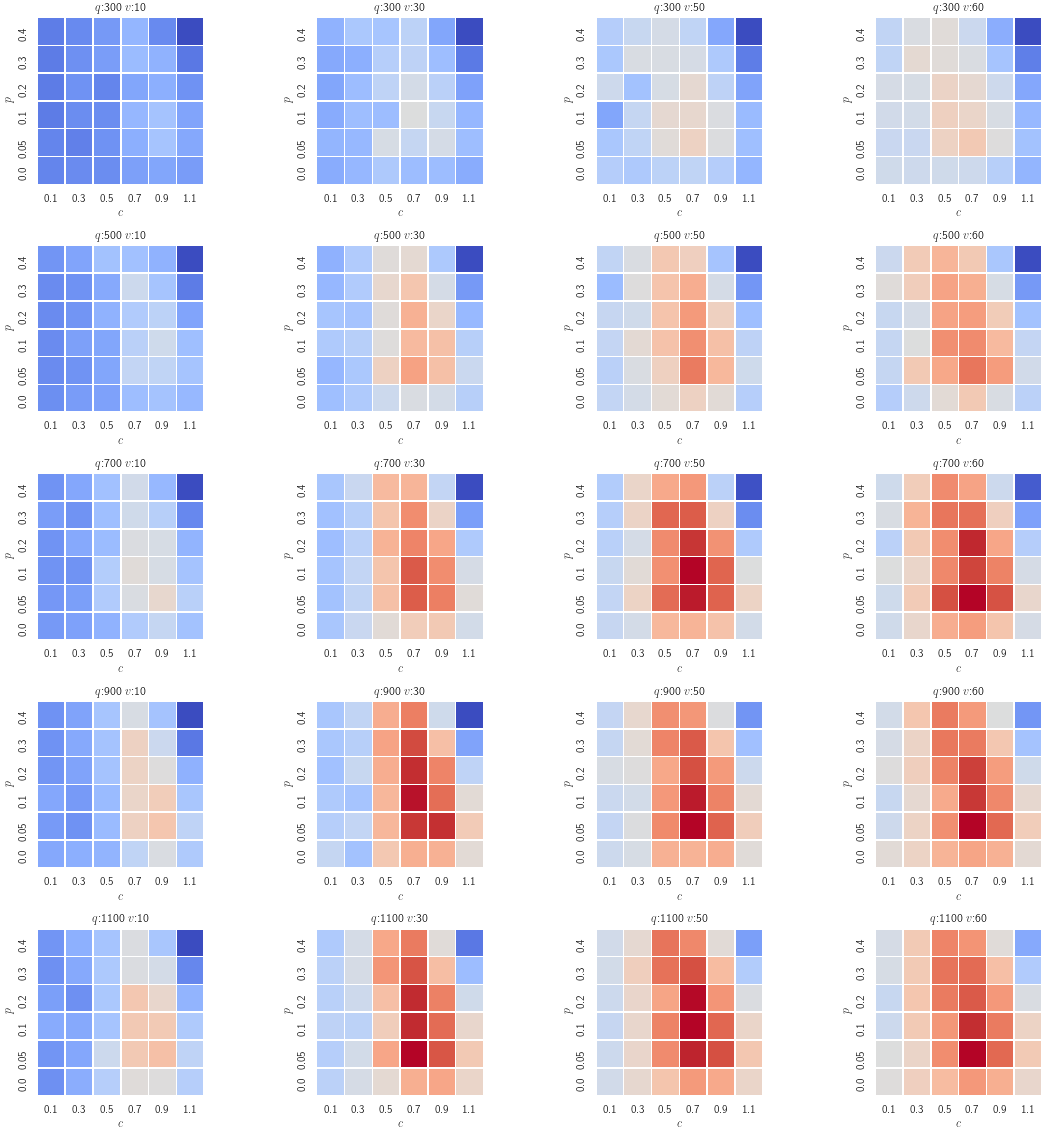

In [16]:
df = means
fig, ax = plt.subplots(means.nP.nunique()-2,means.nV.nunique()-2,figsize = (16,16))
ax = ax.flatten()
i = 0
sns.set(font_scale=1)
for nP in pd.Series(means.nP.unique()).sort_values().values[1:-1]:
    for nV in pd.Series(means.nV.unique()).sort_values().values[[0,2,4,5]]:
        mtx = df[(df.nP == nP) & (df.nV ==nV)].groupby(['$p$', '$c$'])[['commision']].max().unstack().round(0).sort_index(ascending = False)
        mtx.columns = mtx.columns.get_level_values(1)
        mtx = mtx.fillna(-999).astype(int)
        sns.heatmap(mtx, annot=False, fmt = 'd', cmap='coolwarm', ax = ax[i], square = True, cbar = False, linewidths = 0.5, center = 200) #, annot_kws={"size": 8})
        ax[i].set_title('$q$:{} \t $v$:{}'.format(nP,nV), fontsize = 12)
        i+=1 
        print(nP,nV)
fig.tight_layout()
plt.savefig('grid.eps')

In [22]:
best_ones = means.groupby(['nP','nV']).commision.idxmax()
means['best_one'] = means.apply(lambda x: True if x.name in best_ones.values else False, axis = 1)

In [23]:
means[means['best_one']].groupby(['nP','nV'])[['commision','$p$','$c$']].max()

commision   $p$  $c$
nP   nV                        
100  10    29.678717  0.05  0.7
     20    42.965533  0.10  0.3
     30    71.190700  0.10  0.3
     40    85.609183  0.05  0.5
     50   112.835450  0.05  0.3
     60   126.180717  0.05  0.3
300  10   107.614383  0.05  0.9
     20   150.600800  0.10  0.7
     30   199.220233  0.10  0.7
     40   226.115867  0.05  0.7
     50   239.807517  0.05  0.7
     60   260.675800  0.05  0.7
500  10   170.293433  0.10  0.9
     20   291.504733  0.05  0.7
     30   353.170300  0.05  0.7
     40   403.505783  0.05  0.7
     50   427.717383  0.05  0.7
     60   434.127167  0.05  0.7
700  10   225.326150  0.05  0.9
     20   389.844817  0.05  0.9
     30   506.201967  0.10  0.7
     40   546.573533  0.20  0.7
     50   582.597400  0.10  0.7
     60   625.904417  0.05  0.7
900  10   269.557400  0.05  0.9
     20   480.825333  0.10  0.7
     30   608.708333  0.10  0.7
     40   761.885483  0.05  0.7
     50   832.710433  0.05  0.7
     60   889.638283  0.05  0.7
1100 10   282.476133  0.05  0.9
     20   577.498950  0.05  0.7
     30   804.196867  0.05  0.7
     40   870.594083  0.05  0.7
     50   976.876833  0.10  0.7
     60  1090.884550  0.05  0.7
1300 10   313.164133  0.10  0.7
     20   656.477500  0.05  0.7
     30   899.860850  0.05  0.7
     40  1025.683167  0.20  0.7
     50  1208.816583  0.05  0.7
     60  1250.752883  0.05  0.7

---
### Total fare

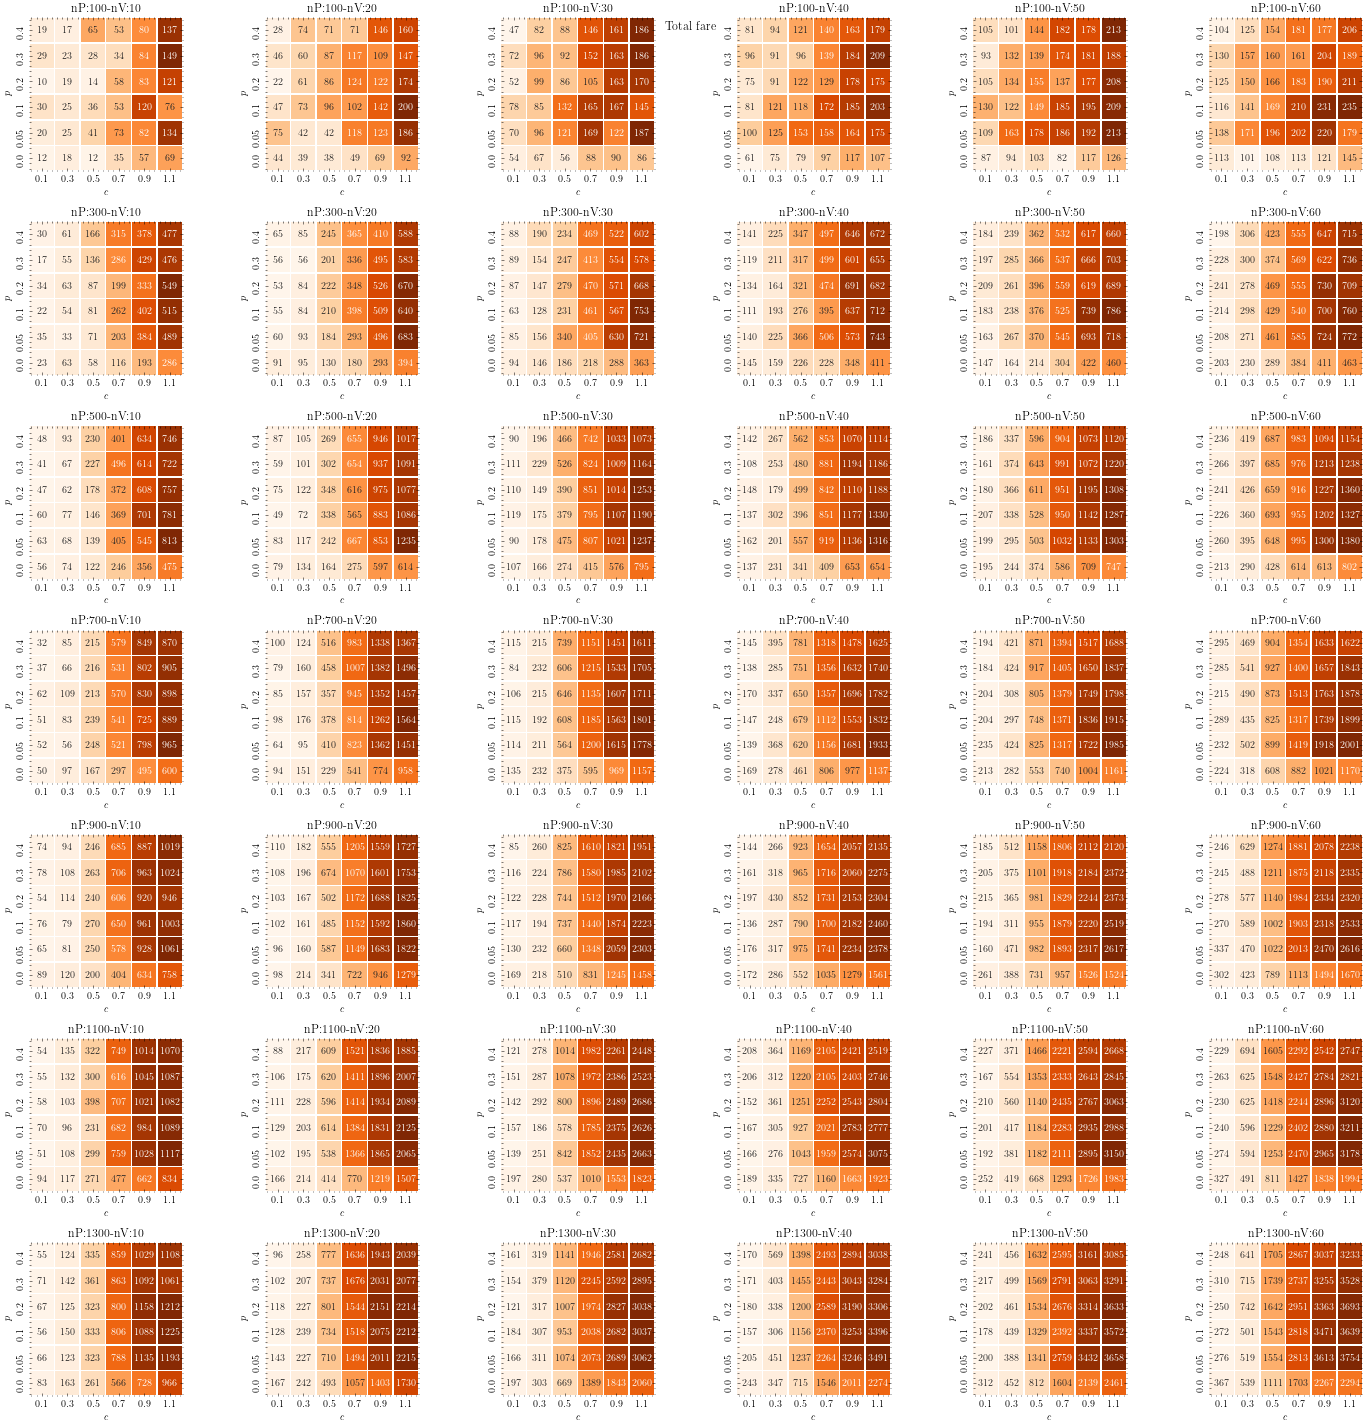

In [8]:
df = means
fig, ax = plt.subplots(means.nP.nunique(),means.nV.nunique(),figsize = (20,20))
ax = ax.flatten()
i = 0
for nP in pd.Series(means.nP.unique()).sort_values().values:
    for nV in pd.Series(means.nV.unique()).sort_values().values:
        mtx = df[(df.nP == nP) & (df.nV ==nV)].groupby(['$p$', '$c$'])[['fare']].max().unstack().round(0).sort_index(ascending = False)
        mtx.columns = mtx.columns.get_level_values(1)
        mtx = mtx.fillna(-999).astype(int)
        sns.heatmap(mtx, annot=True, fmt = 'd', cmap='Oranges', ax = ax[i], square = True, cbar = False, linewidths = 0.5)
        ax[i].set_title('nP:{}-nV:{}'.format(nP,nV))
        i+=1 
fig.suptitle('Total fare')
fig.tight_layout()

---

### Mode choice 

(travellers split between alternative modes)

Text(0.5, 0.98, 'number of users')

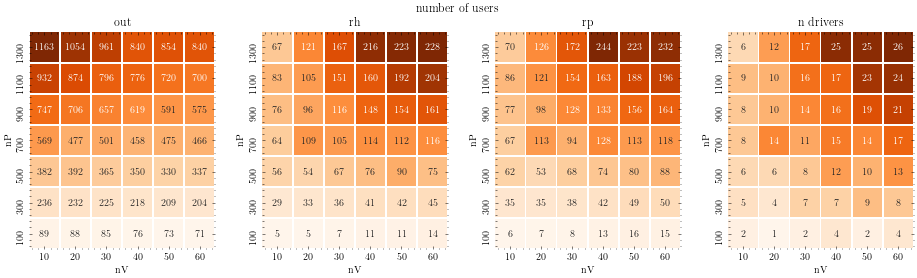

In [9]:
fig, ax = plt.subplots(1,4,figsize = (16,4))
for i, m in enumerate(['out','rh','rp','n drivers']):
    mtx = means[means.best_one].groupby(['nP','nV'])[m].max().unstack().round(0).sort_index(ascending = False).astype(int)
    sns.heatmap(mtx, annot=True, fmt = 'd', cmap='Oranges', ax = ax[i], square = True, cbar = False, linewidths = 0.5)
    ax[i].set_title(m)
fig.suptitle('number of users')

AttributeError: 'DataFrame' object has no attribute 'best_one'

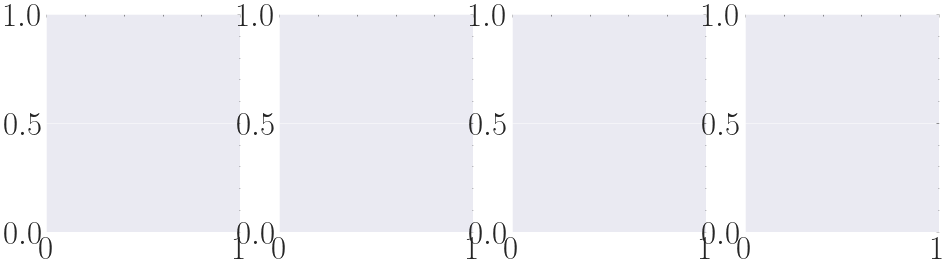

In [20]:
fig, ax = plt.subplots(1,4,figsize = (16,4))
for i, m in enumerate(['opt-out','ride-hailing','ride-pooling','no. drivers']):
    mtx = means[means.best_one].groupby(['nP','nV'])[m].max().unstack().round(2).sort_index(ascending = False)
    sns.heatmap(mtx, annot=True, cmap='Oranges', ax = ax[i], square = True, cbar = False, linewidths = 0.5)
    ax[i].set_title(m)

--- 
### KPIs

other indicators

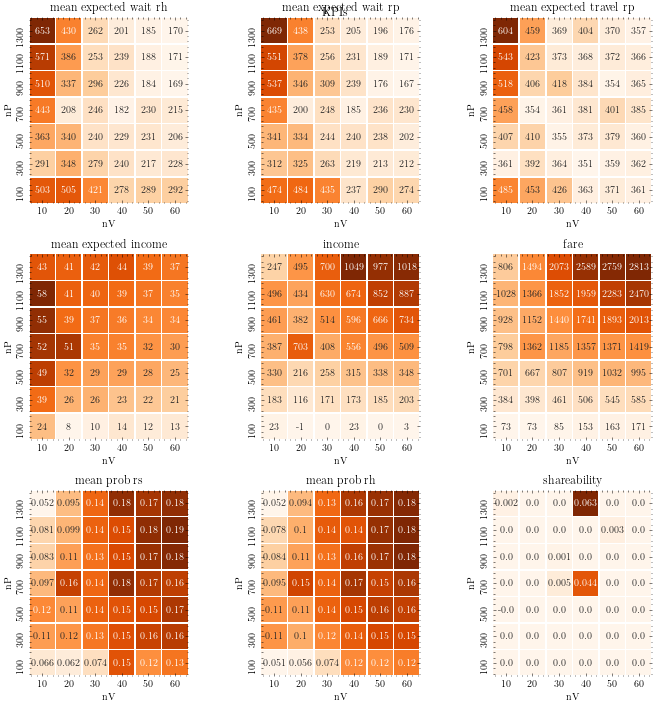

In [10]:
cols = ['mean expected wait rh','mean expected wait rp','mean expected travel rp',
        'mean expected income','income', 'fare', 
        'mean prob rs','mean prob rh', 'shareability' ]
fig, ax = plt.subplots(3,3,figsize = (10,10))
ax = ax.flatten()
for i, col in enumerate(cols):
    if i <6:
        mtx = means[means.best_one].groupby(['nP','nV'])[col].mean().unstack().round(0).sort_index(ascending = False).astype(int)
        sns.heatmap(mtx, annot=True, fmt = 'd', cmap='Oranges', ax = ax[i], square = True, cbar = False, linewidths = 0.5)
    else:
        mtx = means[means.best_one].groupby(['nP','nV'])[col].mean().unstack().round(3).sort_index(ascending = False)
        sns.heatmap(mtx, annot=True, fmt = ".2", cmap='Oranges', ax = ax[i], square = True, cbar = False, linewidths = 0.5)
        
    ax[i].set_title(col)
fig.suptitle('KPIs')
fig.tight_layout()


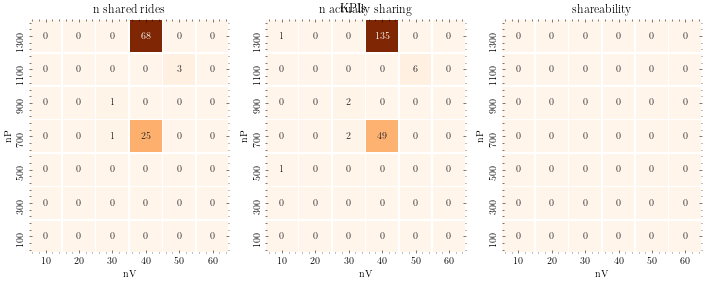

In [11]:
cols = ['n shared rides', 'n actually sharing', 'shareability' ]
fig, ax = plt.subplots(1,3,figsize = (10,4))
ax = ax.flatten()
for i, col in enumerate(cols):
    if i <6:
        mtx = means[means.best_one].groupby(['nP','nV'])[col].mean().unstack().round(0).sort_index(ascending = False).astype(int)
        sns.heatmap(mtx, annot=True, fmt = 'd', cmap='Oranges', ax = ax[i], square = True, cbar = False, linewidths = 0.5)
    else:
        mtx = means[means.best_one].groupby(['nP','nV'])[col].mean().unstack().round(3).sort_index(ascending = False)
        sns.heatmap(mtx, annot=True, fmt = ".2", cmap='Oranges', ax = ax[i], square = True, cbar = False, linewidths = 0.5)
        
    ax[i].set_title(col)
fig.suptitle('KPIs')
fig.tight_layout()


--- 
### Pooling

number of travellers actually sharing

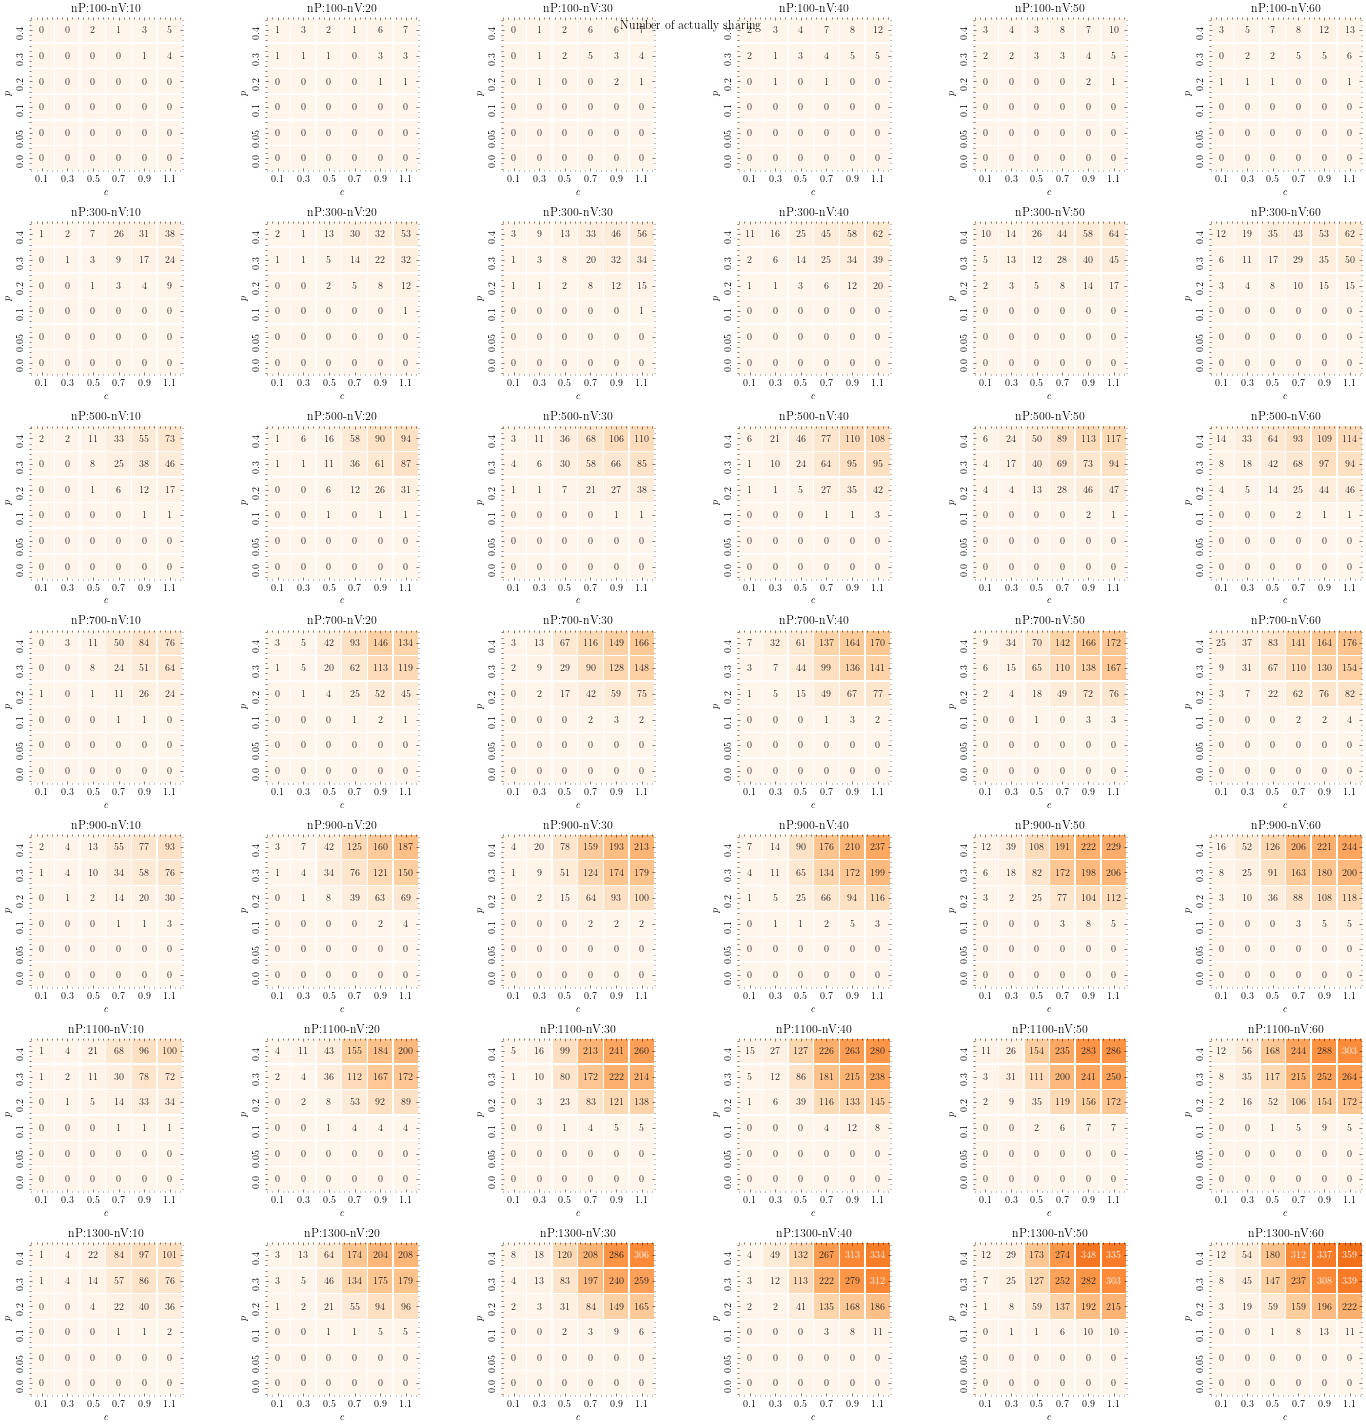

In [12]:
df = means
fig, ax = plt.subplots(means.nP.nunique(),means.nV.nunique(),figsize = (20,20))
ax = ax.flatten()
i = 0
for nP in pd.Series(means.nP.unique()).sort_values().values:
    for nV in pd.Series(means.nV.unique()).sort_values().values:
        mtx = df[(df.nP == nP) & (df.nV ==nV)].groupby(['$p$', '$c$'])[['n actually sharing']].max().unstack().round(0).sort_index(ascending = False)
        mtx.columns = mtx.columns.get_level_values(1)
        mtx = mtx.fillna(-999).astype(int)
        sns.heatmap(mtx, annot=True, fmt = 'd', cmap='Oranges', ax = ax[i], square = True, cbar = False, center = 300, linewidths = 0.5)
        ax[i].set_title('nP:{}-nV:{}'.format(nP,nV))
        i+=1 
fig.suptitle('Number of actually sharing')
fig.tight_layout()

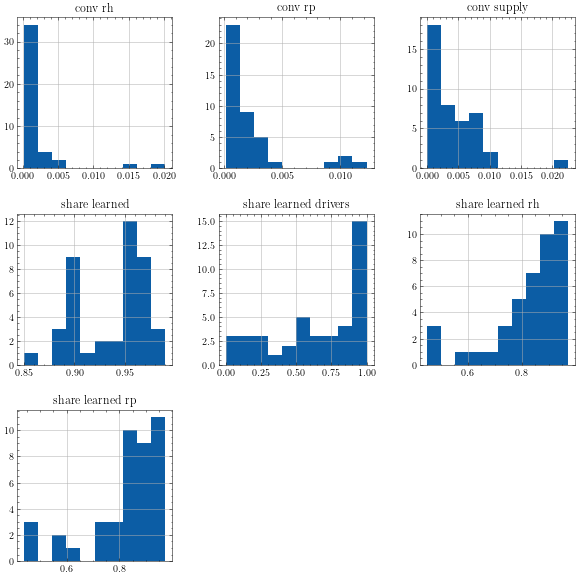

In [12]:
import numpy as np
for col in ['learned','learned rp','learned rh']:
    means['share '+col] = means[col]/means.nP
means['share learned drivers'] = means['learned drivers']/means.nV
_ = means[means['best_one']][['conv rp', 'conv rh', 'conv supply',
                              'share learned drivers','share learned','share learned rp','share learned rh']].hist(figsize= (10,10))


---
(c) Rafal Kucharski, TU Delft/GMUM, 2021